# 自己符号化器
- TensorFlow、Kerasを用いて自己符号化器（AutoEncoder）を実装
- MNISTデータセットの画像を学習させて、復元してみよう
- [参考]
[Building Autoencoders in Keras - The Keras Blog](https://blog.keras.io/building-autoencoders-in-keras.html)

## 1. ライブラリの読み込み

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# データセットの読み込み
from tensorflow.keras.datasets import mnist
# ニューラルネットワークの層
from tensorflow.keras.layers import Input, Dense
# 層をまとめてネットワークを構築
from tensorflow.keras.models import Model

## 2. データの読み込み
- MNIST（手書き数字のデータセット）を用いる

In [2]:
# MNISTデータセットの読み込み
(X_train, y_train),(X_test, y_test) = mnist.load_data()

# 28*28の画像データを、784次元のベクトルに変換
# 画素値を255で割ることで正規化（画素値=0～255）
X_train = X_train.reshape(-1, 784) / 255
X_test = X_test.reshape(-1, 784) / 255

## 3. モデルの構築

### 3-1. ネットワーク全体

In [3]:
# 中間層の次元数
encoding_dim = 36

# 入力層の定義
input_img = Input(shape=(784,))
# 入力層〜中間層を定義
# activationで活性化関数を指定
# 2つ目の（）で前の層を指定
encoded = Dense(encoding_dim, activation='relu')(input_img)
# 中間層〜出力層を定義
decoded = Dense(784, activation='sigmoid')(encoded)

# 入力層〜出力層までをつなげて、ネットワークを完成させる
autoencoder = Model(inputs=input_img, outputs=decoded)
# 学習条件の定義
autoencoder.compile(
    # 最適化手法
    optimizer='adam', 
    # 損失関数
    # 画素値の回帰問題として扱う
    loss='mean_squared_error' 
)
# ネットワーク全体の中身を確認
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 36)                28260     
                                                                 
 dense_1 (Dense)             (None, 784)               29008     
                                                                 
Total params: 57,268
Trainable params: 57,268
Non-trainable params: 0
_________________________________________________________________


### 3-2. エンコーダとデコーダ

In [4]:
# 計算結果を利用しやすくするために、エンコーダとデコーダを分離
# エンコーダ部分だけのモデル
# autoencoderと層を共有している
encoder = Model(input_img, encoded)
# エンコーダの中身を確認
print("*** encoder ***")
print(encoder.summary(), "\n")

# デコーダ部分だけのモデル
# autoencoderと層を共有している
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
# デコーダの中身を確認
print("*** decoder ***")
decoder.summary()

*** encoder ***
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 36)                28260     
                                                                 
Total params: 28,260
Trainable params: 28,260
Non-trainable params: 0
_________________________________________________________________
None 

*** decoder ***
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 36)]              0         
                                                                 
 dense_1 (Dense)             (None, 784)               29008     
                                                                 

## 4. モデルの学習

In [5]:
fit = autoencoder.fit(
    # 訓練用データ
    X_train, X_train, 
    # エポック数（学習を行う回数）
    epochs=10, 
    # バッチサイズ（一回の更新で利用するデータの数）
    batch_size=256,
    # 学習時にデータをシャッフル
    shuffle=True, 
    # 検証用データ
    validation_data=(X_test, X_test) 
) 

# 各epochにおける損失をdfに格納
df = pd.DataFrame(fit.history)

Epoch 1/10
235/235 [==============================] - 2s 6ms/step - loss: 0.0675 - val_loss: 0.0380
Epoch 2/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0321 - val_loss: 0.0271
Epoch 3/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0243 - val_loss: 0.0212
Epoch 4/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0196 - val_loss: 0.0173
Epoch 5/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0163 - val_loss: 0.0146
Epoch 6/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0139 - val_loss: 0.0126
Epoch 7/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0123 - val_loss: 0.0113
Epoch 8/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0112 - val_loss: 0.0104
Epoch 9/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0104 - val_loss: 0.0099
Epoch 10/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0099 - val_loss: 0.0095

## 5. 学習結果の確認

### 5-1. 学習曲線の表示

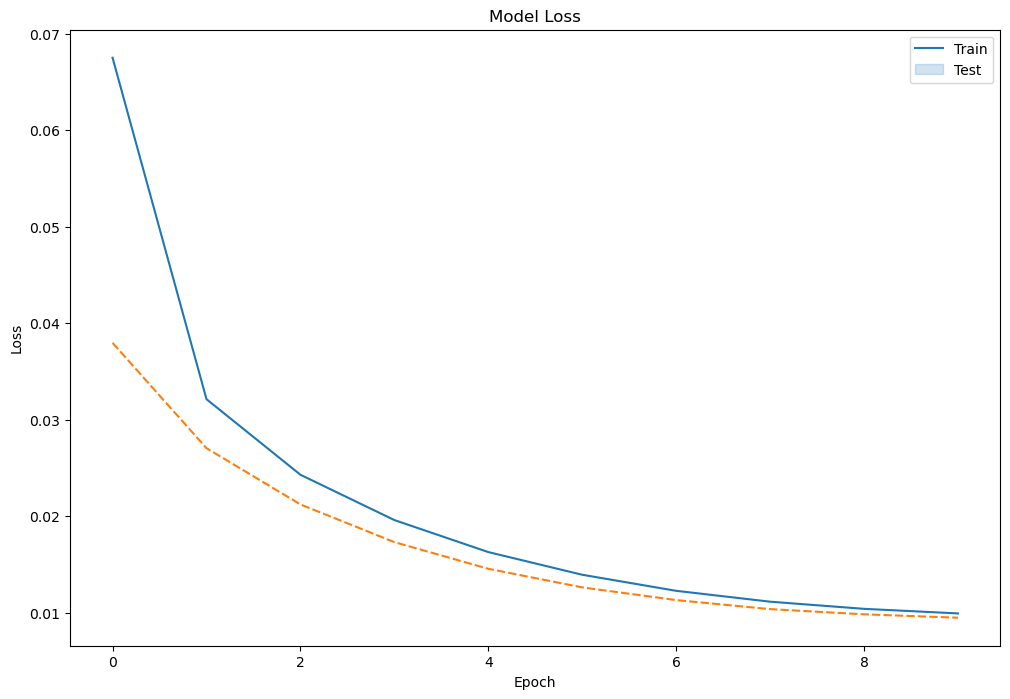

In [6]:
# 表示領域の作成
plt.figure(figsize=(12, 8))
# Loss (損失)をグラフ化
sns.lineplot(data=df[["loss", "val_loss"]])

# グラフタイトルの設定
plt.title('Model Loss')
# 軸ラベルの設定
plt.ylabel('Loss')
plt.xlabel('Epoch')
# 凡例の位置調整
plt.legend(['Train', 'Test'], loc='best')
plt.show()

### 5-2. 予測の実行

In [7]:
# 中間層の値を計算
encoded_imgs = encoder.predict(X_test)

# 出力層の値を計算
decoded_imgs = decoder.predict(encoded_imgs)
# decoded_imgs = autoencoder.predict(X_test) # としても同じ

313/313 [==============================] - 0s 1ms/step


### 5-3. 予測結果の可視化

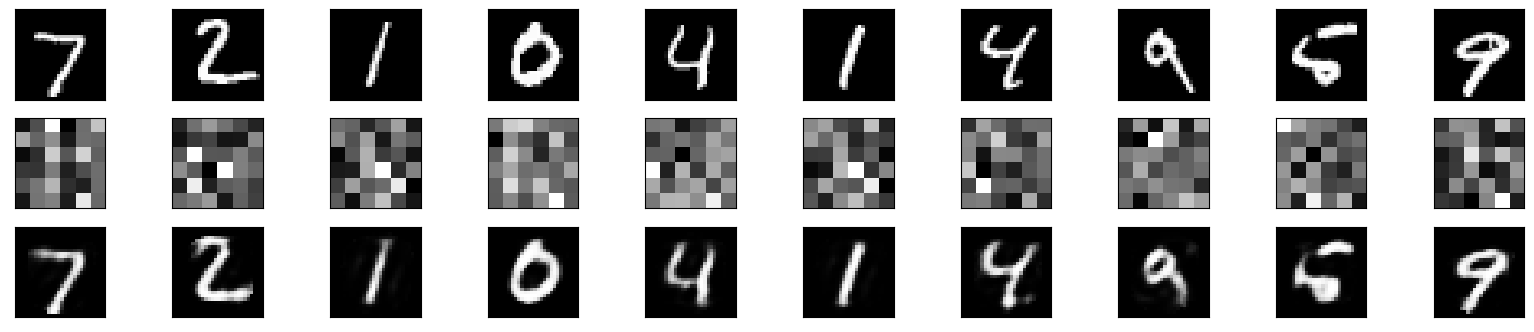

In [8]:
# 表示する画像の枚数
n = 10  
# 表示領域の作成
plt.figure(figsize=(20, 4))

# n枚分繰り返す
for i in range(n):
    # 表示位置の設定
    ax = plt.subplot(3, n, i + 1)
    # 元の画像を表示
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray() 
    # 軸を非表示にする
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 表示位置の設定
    ax = plt.subplot(3, n, i + 1 + n)
    # 中間層の値を画像として表示
    # 画像サイズは、encoding_dimに合わせて変更する
    plt.imshow(encoded_imgs[i].reshape(6,6)) 
    plt.gray()
    # 軸を非表示にする
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # 表示位置の設定
    ax = plt.subplot(3, n, i + 1 + 2*n)
    # 出力層の値を画像として表示
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    # 軸を非表示にする
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### [演習]
* Epoch数を減らすと再構成画像がどうなるか確認してみよう
* 中間層のノード数を減らすと再構成画像がどうなるか確認してみよう